# Figure 2

In [1]:
import numpy as np
from scipy.optimize import root
from dataclasses import dataclass
import matplotlib.pyplot as plt
import import_ipynb
import GeneralMethod  # Call functions from GeneralMethod without duplicating code
import EvolutionOfChannelBalance # Call functions from EvolutionOfBobsBalance without duplicating code

Consider the setting in Section 5.3.1, i.e., $(\tau_n, \Delta_n)_{n \geq 1}$ is a marked point process, where $\tau_n$ is the $n^{th}$ point of a Poisson process with intensity $1040 \lambda^2$ and $\Delta_n$ are IID mixture exponentially distributed random variables with probability density
\begin{equation}
    f^\lambda(x) = \frac{1}{3}\left(\frac{\lambda}{2}\exp\left(\frac{\lambda}{2}x\right)\right)\mathbf{1}_{\mathbb{R}_-}(x) + \frac{2}{3} \left(\lambda \exp(-\lambda x)\right)\mathbf{1}_{\mathbb{R}_+}(x).
\end{equation}

Fix $\lambda = \tfrac{1}{5}$. In this setting, Bob makes exponential payments with mean $5$, Alice makes exponential payments with mean $10$, there are $1040/25$ payments per unit time and Bob is expected to make double the payments Alice makes.

## Optimal Policy

Using Figure_8_9.ipynb, the optimal deposits are $l_A = 53$ and $l_B = 73$. The optimal policy is depicted below.

In [4]:
lam_A = 1/10  # Alice's exponential distribution parameter
lam_B = 1/5  # Bob's exponential distribution parameter
p = 2/3  # Probability Bob makes a payment

def I_mix(x, y, p, lam_A, lam_B):
    if x >= 0:
        return p * (np.exp(-lam_B * x) - np.exp(-lam_B * y))
    elif y <= 0:
        return (1 - p) * (np.exp(lam_A * y)-np.exp(lam_A * x))
    else:
        return 1 - (1 - p) * np.exp(lam_A * x) - p * np.exp(-lam_B * y)

def I(x,y):
    return I_mix(x, y, p, lam_A, lam_B)

params = GeneralMethod.PaymentParams(
    l_A = 53, 
    l_B = 73, 
    C = 1.0, 
    D = 2.0, 
    alpha = (1040 * 1/5 ** 2) / (1040 * 1/5 ** 2 + 0.02), 
    n = 1,
    I = I  # The function I defined above
)

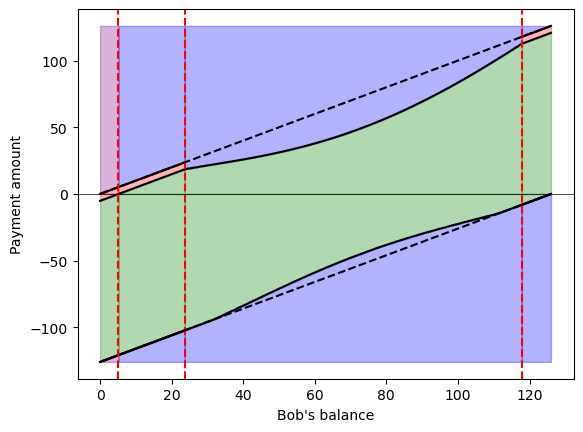

In [6]:
optimal_cost_vector = GeneralMethod.T_n(params) # Compute the optimal cost vector

GeneralMethod.Optimal_Policy(optimal_cost_vector, 3, params, unidirectional=False)

## Channel Balance Evolution

First consider a single path of the payment stream over the interval $[0, T]$.

In [10]:
rate_lambda = 1040/25  # The intensity of the Poisson process
r = 0.02  # Interest rate
T = 5  # Time horizon
k = 3  # Second fine-tuning parameter
m = (2 ** k) * params.n

finer_optimal_cost_vector = GeneralMethod.transform_vector_k_times(optimal_cost_vector, k)

In [120]:
path = EvolutionOfChannelBalance.simulate_path(rate_lambda, p, lam_A, lam_B, T)

In [122]:
T_1 = GeneralMethod.calculate_threshold_indices(finer_optimal_cost_vector, params.C, params.D, params.l_A, params.l_B, m)[0]/(2*m)
T_2 = GeneralMethod.calculate_threshold_indices(finer_optimal_cost_vector, params.C, params.D, params.l_A, params.l_B, m)[1]/(2*m)
T_3 = GeneralMethod.calculate_threshold_indices(finer_optimal_cost_vector, params.C, params.D, params.l_A, params.l_B, m)[2]/(2*m)
T_4 = GeneralMethod.calculate_threshold_indices(finer_optimal_cost_vector, params.C, params.D, params.l_A, params.l_B, m)[3]/(2*m)

In [124]:
delta_plus = GeneralMethod.delta_plus(finer_optimal_cost_vector, params.C, params.D, params.l_A, params.l_B, m)
delta_minus = GeneralMethod.delta_minus(finer_optimal_cost_vector, params.C, params.D, params.l_A, params.l_B, m)

In [125]:
def delta_plus_function(b):
    # Determine the index i based on x and m
    i = int(2 * m * b)
    # Return the value of delta_plus at index i
    return delta_plus[i]

def delta_minus_function(b):
    # Determine the index i based on x and m
    i = int(2 * m * b)
    # Return the value of delta_plus at index i
    return delta_minus[i]

In [128]:
evolution = EvolutionOfChannelBalance.evolve_channel(path, params.l_A, params.l_B, T_1, T_2, T_3, T_4, delta_minus_function, delta_plus_function, params.C, params.D, params.n, k)

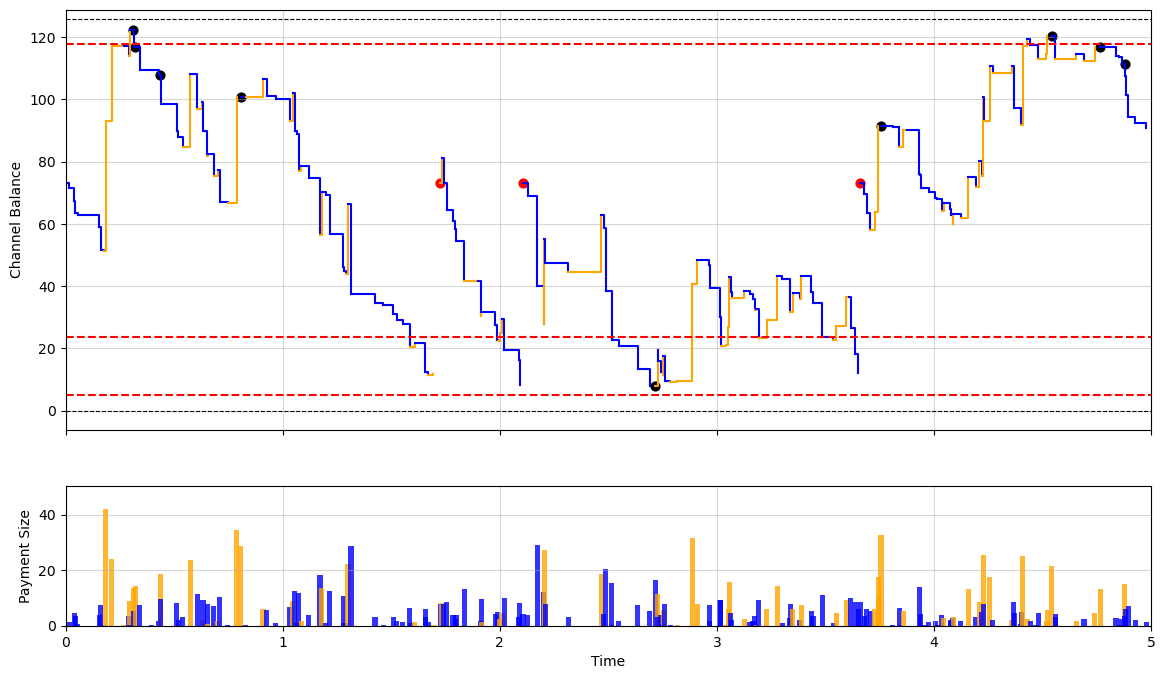

In [130]:
EvolutionOfChannelBalance.visualize_channel_evolution(evolution, path, params.l_A, params.l_B, T_1, T_2, T_3, T_4, T)
plt.savefig('evolution.pdf')

## Computing the Expected Cost

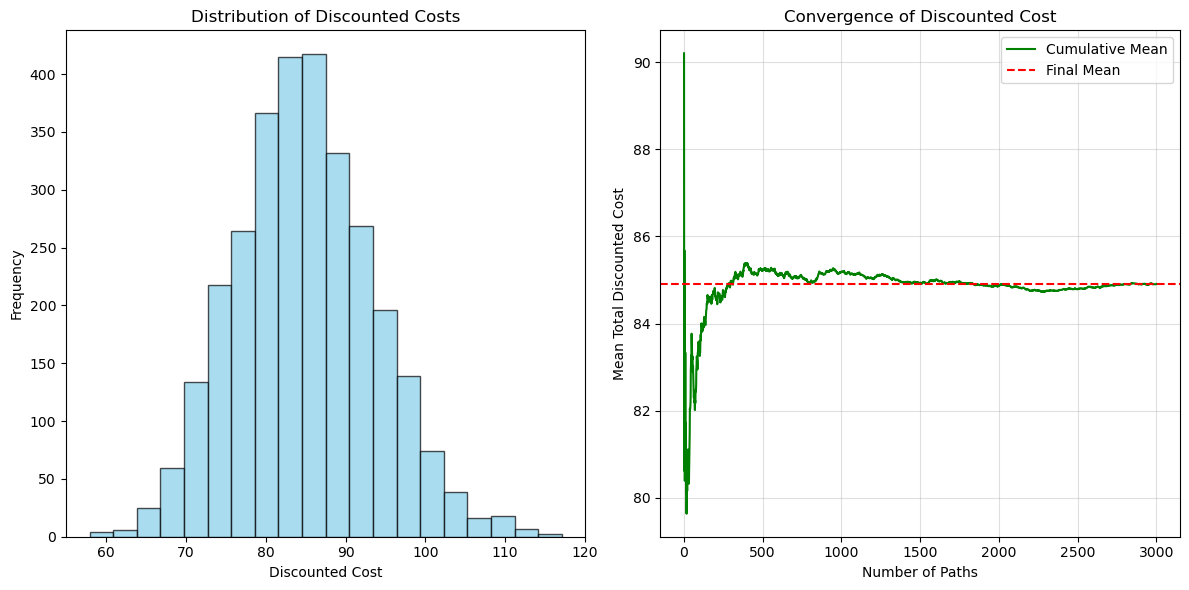

Expected Total Discounted Cost (Mean): 84.9096
Standard Deviation: 8.6649


In [136]:
T = 200  # New large horizon 
num_paths = 3000  # Number of paths

costs = EvolutionOfChannelBalance.simulate_multiple_paths(num_paths, rate_lambda, p, lam_A, lam_B, T, 
                                 params.l_A, params.l_B, T_1, T_2, T_3, T_4, delta_minus_function, delta_plus_function, params.C, params.D, r, params.n, k)

# Visualize the results
EvolutionOfChannelBalance.visualize_cost_distribution(costs, num_paths)

# Print summary statistics
print(f"Expected Total Discounted Cost (Mean): {np.mean(costs):.4f}")
print(f"Standard Deviation: {np.std(costs):.4f}")

In [142]:
# The opportunity cost plus the expected discounted cost arising from transactions over the interval [0, 200] is:

(53+73)*(1-np.exp(-r*T)) + 84.9096  # Approximately 212, which is what was expected.

208.6018295000195